Código Geral

In [2]:
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import ast
from collections import Counter
from pandas import DataFrame

sns.set_theme()


start_year = 2013
end_year = 2023

movies_data_by_year = {}


In [3]:
def get_file_path(year):
    data_common_name = 'prepared_data/tmdb_dump'
    return f'{data_common_name}-{year}.csv'

def read_data_set(year):
    file_path = get_file_path(year)
    return pd.read_csv(file_path, encoding='utf-8', lineterminator='\n')

In [46]:
for year in range(start_year, end_year+1):
    data = read_data_set(year)
    movies_data_by_year[year] = data
    if 'all' in movies_data_by_year:
        movies_data_by_year['all'] = pd.concat([movies_data_by_year['all'], data])
    else:
        movies_data_by_year['all'] = data

Análise dos Dados numéricos (Quantidade e Média)

In [5]:
def movies_count(year):
    df =  movies_data_by_year[year]
    return len(df.index)

def budget_mean(year):
    df: DataFrame = movies_data_by_year[year]
    return df.loc[:, 'budget'].mean()

def revenue_mean(year):
    df: DataFrame = movies_data_by_year[year]
    return df.loc[:, 'revenue'].mean()

def runtime_mean(year):
    df: DataFrame = movies_data_by_year[year]
    return df.loc[:, 'runtime'].mean()

def vote_count_mean(year):
    df: DataFrame = movies_data_by_year[year]
    return df.loc[:, 'vote_count'].mean()

def vote_mean_by_year(year):
    df: DataFrame = movies_data_by_year[year]
    return vote_mean(df)

def vote_mean(df):
    df["weight"] = df["vote_count"] * df["vote_average"]
    return df["weight"].sum() / df["vote_count"].sum()
    
def vote_deviation(df):
    mean = vote_mean(df)
    df["weight"] = df["vote_count"] * df["vote_average"]    
    df["deviation"] = ((df["vote_average"] - mean)**2) * df["weight"]
    
    upper_eq_part = df["deviation"].sum()
    
    weight_sum = df["weight"].sum()
    n = df["weight"].count()
    bottom_eq_part = weight_sum * (n - 1) / n
    
    return math.sqrt(upper_eq_part/bottom_eq_part)

Calculo do desvio padrão amostral dos dados numéricos

In [6]:
df_concat = movies_data_by_year[start_year]
for year in range(start_year+1, end_year+1):
    df_concat = pd.concat([df_concat, movies_data_by_year[year]])
    
numeric_columns = ["budget", "revenue", "runtime", "vote_count"]
print(df_concat[numeric_columns].std())
print("Deviation: ", vote_deviation(df_concat))


budget        5.004297e+07
revenue       2.163519e+08
runtime       2.107148e+01
vote_count    3.680442e+03
dtype: float64
Deviation:  0.7151867182957711


In [7]:
for year in range(start_year, end_year+1):
    values = year, movies_count(year), budget_mean(year), revenue_mean(year), runtime_mean(year), vote_count_mean(year), vote_mean_by_year(year)
    for value in values:
        print("{:.2f}".format(value), " & " , end="")
    print("")


2013.00  & 333.00  & 29133697.35  & 83963872.83  & 111.97  & 2356.57  & 6.79  & 
2014.00  & 317.00  & 27739095.79  & 88809630.21  & 109.73  & 2624.77  & 7.01  & 
2015.00  & 301.00  & 28413424.29  & 96225236.56  & 112.00  & 2407.86  & 6.81  & 
2016.00  & 339.00  & 30959884.17  & 92686166.47  & 111.99  & 2464.51  & 6.83  & 
2017.00  & 307.00  & 29728204.99  & 103942389.76  & 112.44  & 2593.88  & 6.96  & 
2018.00  & 275.00  & 30404534.53  & 109654092.13  & 112.82  & 2334.57  & 7.00  & 
2019.00  & 251.00  & 32862991.07  & 119087300.21  & 111.95  & 2376.76  & 7.14  & 
2020.00  & 132.00  & 26047200.65  & 39661077.16  & 105.89  & 1539.45  & 7.04  & 
2021.00  & 158.00  & 45537524.30  & 93868823.13  & 115.16  & 2124.64  & 7.21  & 
2022.00  & 173.00  & 39368203.98  & 105105561.14  & 115.13  & 1499.87  & 7.11  & 
2023.00  & 207.00  & 44851926.51  & 106455189.39  & 117.57  & 1097.42  & 7.14  & 


Mapas coropléticos

In [8]:
import numpy as np
import folium
import geopandas as gpd
from folium import Choropleth

for year in range (start_year, end_year+1):
    df = movies_data_by_year[year]
    df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    df_countries = df.explode('production_countries', ignore_index=True)
    country_counts = df_countries['production_countries'].value_counts().reset_index()
    country_counts.columns = ['production_country', 'count']
    country_counts['count'] = np.log10(country_counts['count'])

    # Carrega o arquivo GeoJSON com as fronteiras dos países
    geo_json_data = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json')

    # Renomeia as colunas para corresponder aos nomes do GeoJSON
    geo_json_data = geo_json_data.rename(columns={"name": "production_country"})

    geo_countries_list = geo_json_data["production_country"].tolist()
   
    country_mapping = {
        'Hong Kong': 'China',  # Considera Hong Kong como parte da China
        'Serbia': 'Republic of Serbia',
        'Aruba': 'Netherlands',  # Considera Aruba como parte dos Países Baixos
        'Singapore': 'Malaysia',
        'Congo': 'Democratic Republic of the Congo',
        'Bahamas': 'The Bahamas',
        'Guadaloupe': 'France' # Considera Guadalupe como parte da frança
    }

    country_counts.replace(country_mapping, inplace=True)
    
    df_countries_list = country_counts['production_country'].tolist()
    missing_countries = [country for country in df_countries_list if country not in geo_countries_list]

    # Exibe os países que não têm correspondência
    print("Países que não correspondem no GeoJSON:")
    print(missing_countries)
    

    # Inicializa o mapa
    m = folium.Map(location=[45, -90], zoom_start=1.5)

    # Adiciona o choropleth map ao mapa
    Choropleth(
        geo_data=geo_json_data,
        name='choropleth',
        data=country_counts,
        columns=['production_country', 'count'],
        key_on='feature.properties.production_country',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Log10(Número de Filmes por País)',
    ).add_to(m)

    # Adiciona os controles de camada
    folium.LayerControl().add_to(m)

    # Exibe o mapa
    m.save(f'choropleth/choropleth_paises_produtores-{year}.html')
    m


Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]


Nuvem de Palavras, grafo e histograma de generos de filmes

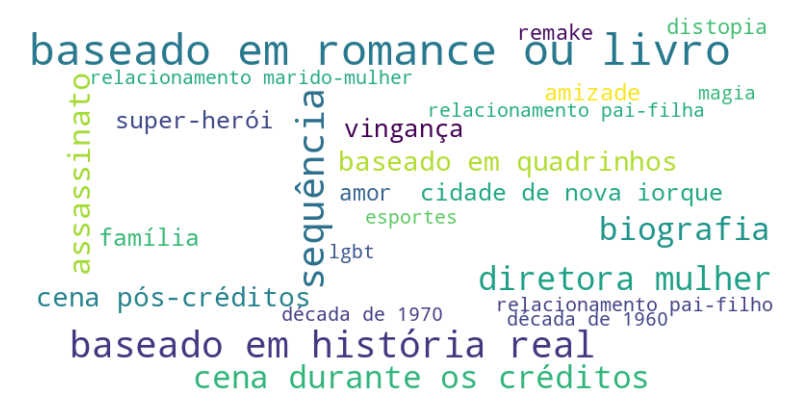

['based on novel or book', 'sequel', 'based on true story', 'woman director', 'biography', 'duringcreditsstinger', 'murder', 'based on comic', 'aftercreditsstinger', 'revenge', 'new york city', 'superhero', 'family', 'friendship', 'love', 'dystopia', 'remake', 'lgbt', '1970s', 'husband wife relationship', 'parent child relationship', 'sports', 'father daughter relationship', 'magic', '1960s']
Counter({('based on true story', 'biography'): 76, ('based on comic', 'superhero'): 62, ('aftercreditsstinger', 'duringcreditsstinger'): 54, ('based on novel or book', 'based on true story'): 41, ('aftercreditsstinger', 'superhero'): 39, ('aftercreditsstinger', 'based on comic'): 38, ('based on comic', 'duringcreditsstinger'): 38, ('duringcreditsstinger', 'superhero'): 35, ('based on novel or book', 'biography'): 33, ('duringcreditsstinger', 'sequel'): 33, ('aftercreditsstinger', 'sequel'): 30, ('based on novel or book', 'love'): 26, ('based on novel or book', 'sequel'): 24, ('based on novel or bo

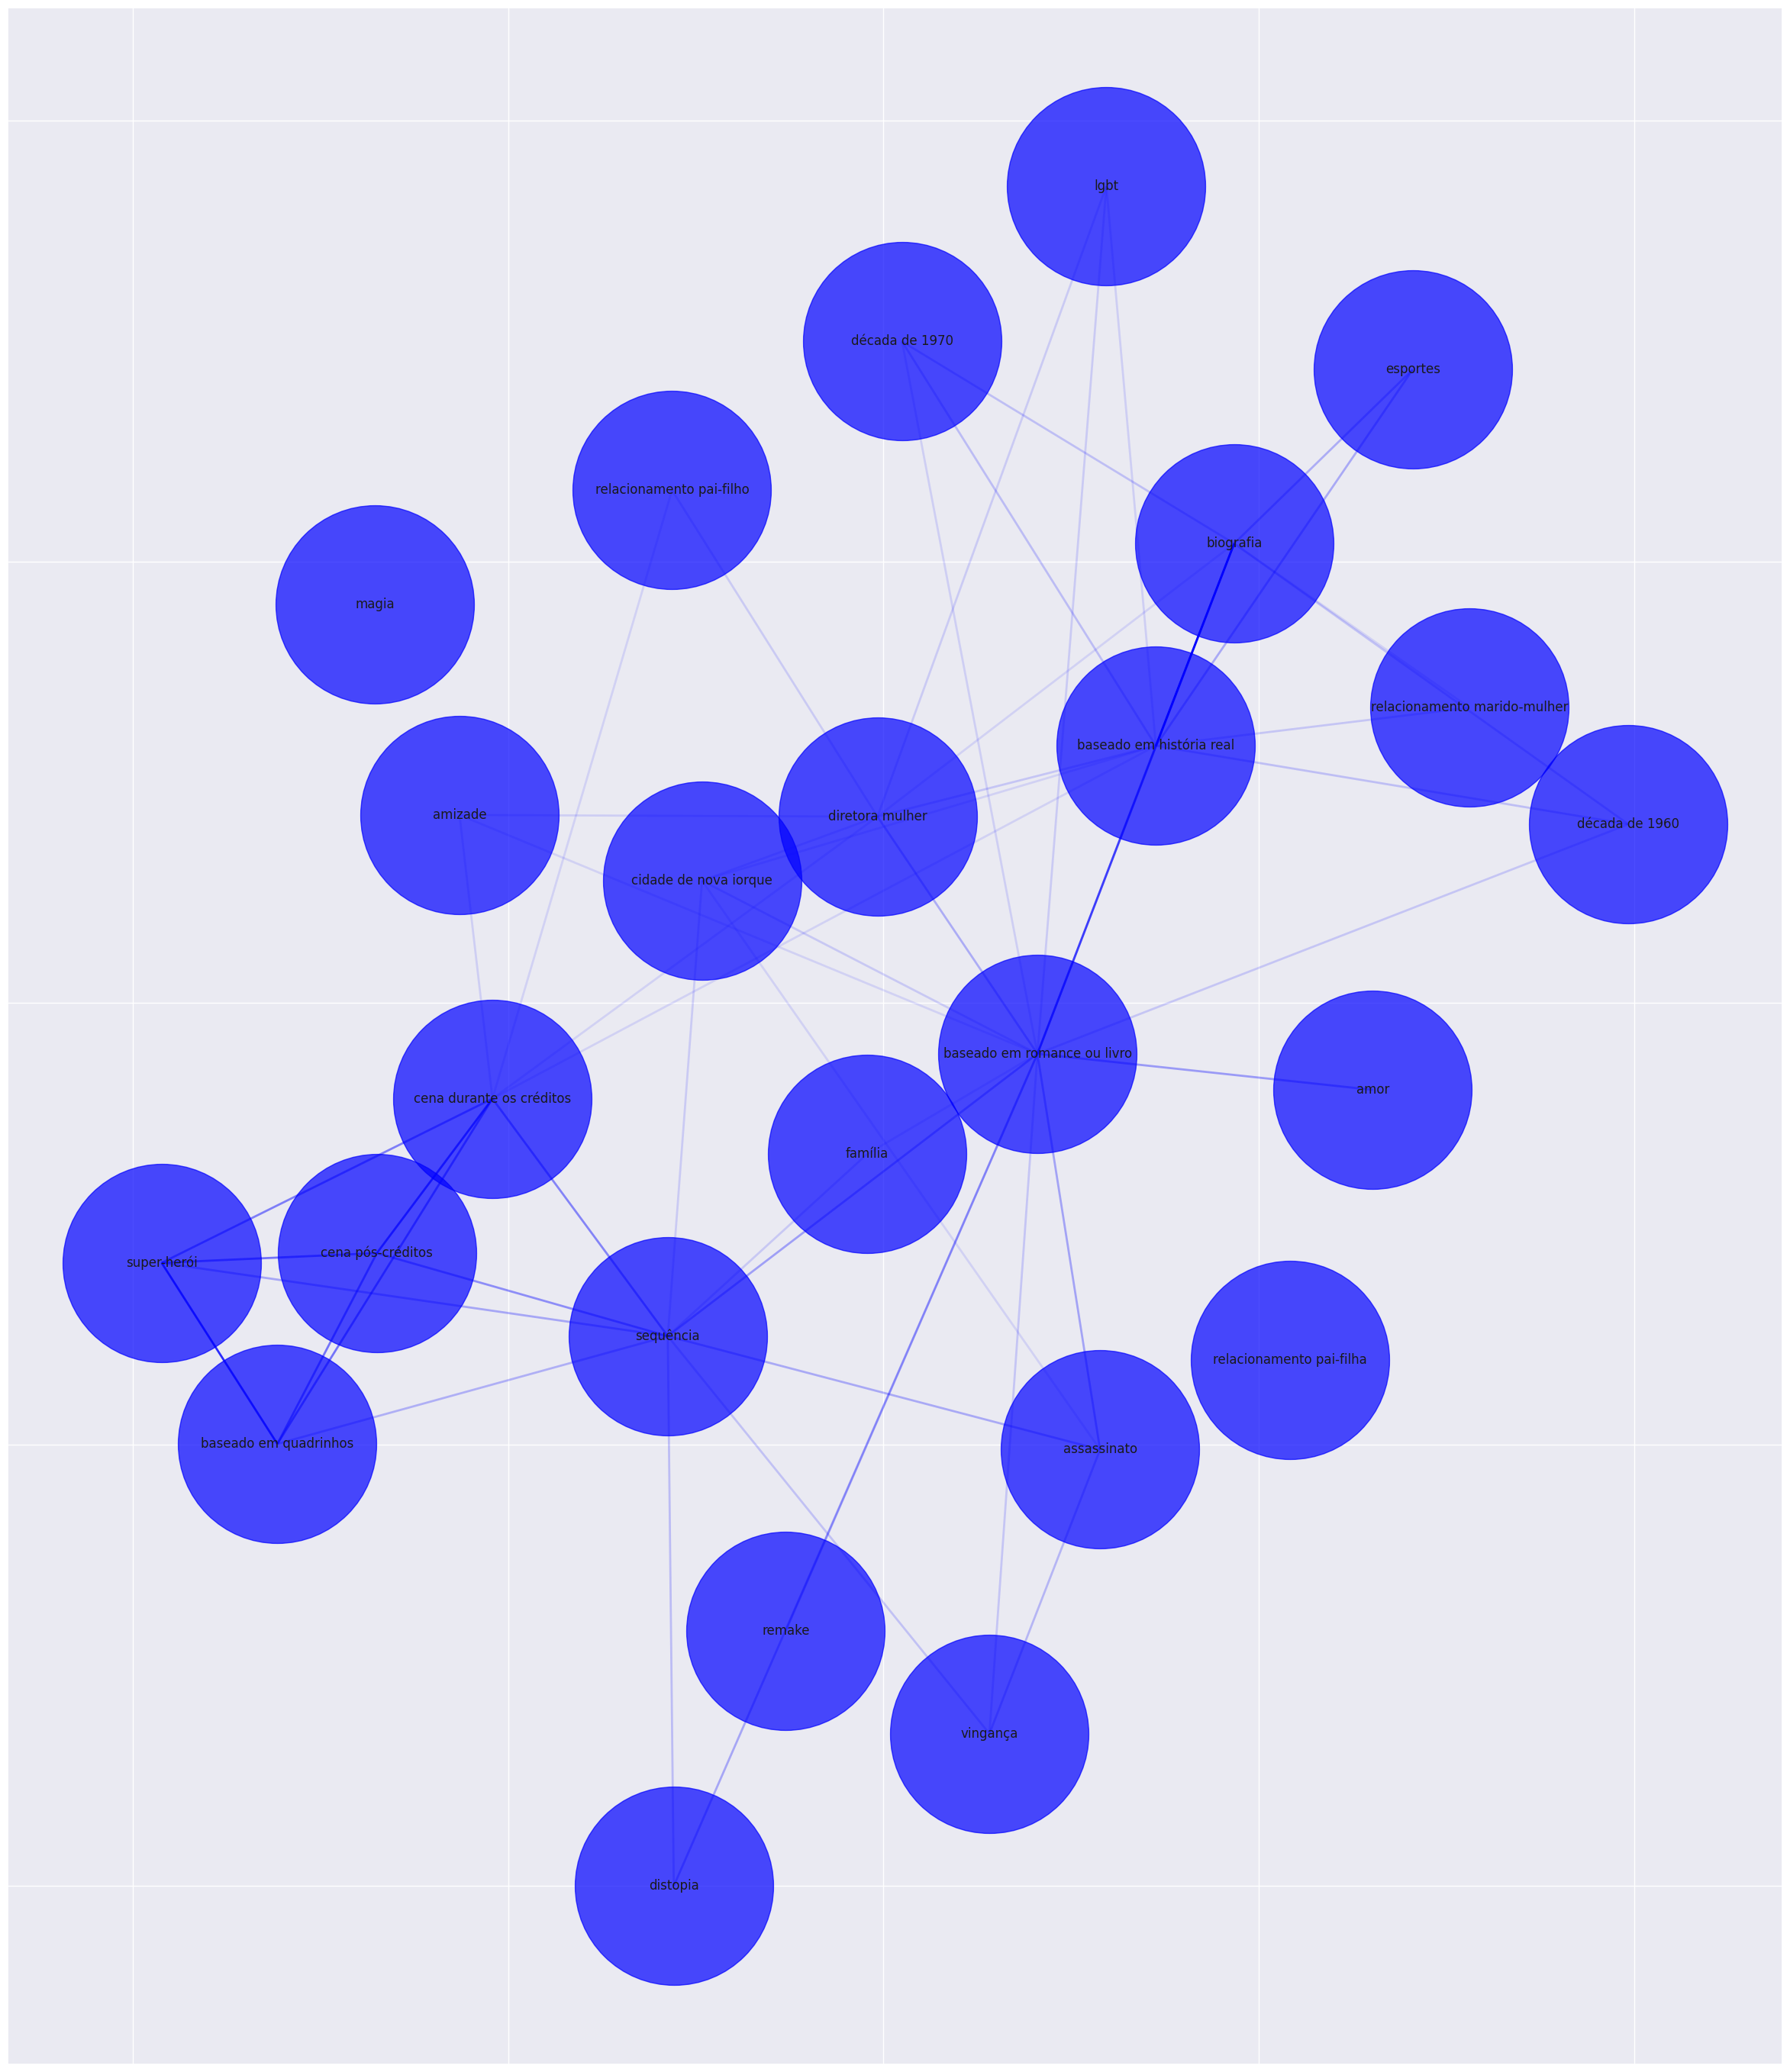

In [9]:
from wordcloud import WordCloud
from itertools import combinations
import networkx as nx

df = movies_data_by_year['all']

quantity_of_words = 25

# Mapa de palavaras para keywords
df['keywords'] =  df['keywords'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_keywords = df.explode('keywords', ignore_index=True).dropna(subset='keywords')['keywords']
all_keywords = [str(keyword).strip() for keyword in df_keywords]
keyword_counts = Counter(all_keywords)
keyword_counts_most_common = keyword_counts.most_common(quantity_of_words)

translated_keywords = {
    'based on novel or book': 'baseado em romance ou livro',
    'sequel': 'sequência',
    'based on true story': 'baseado em história real',
    'woman director': 'diretora mulher',
    'biography': 'biografia',
    'duringcreditsstinger': 'cena durante os créditos',
    'murder': 'assassinato',
    'based on comic': 'baseado em quadrinhos',
    'aftercreditsstinger': 'cena pós-créditos',
    'revenge': 'vingança',
    'new york city': 'cidade de nova iorque',
    'superhero': 'super-herói',
    'family': 'família',
    'friendship': 'amizade',
    'love': 'amor',
    'lgbt': 'lgbt',
    'dystopia': 'distopia',
    'remake': 'remake',
    'husband wife relationship': 'relacionamento marido-mulher',
    '1970s': 'década de 1970',
    '1960s': 'década de 1960',
    'parent child relationship': 'relacionamento pai-filho',
    'magic': 'magia',
    'sports': "esportes",
    'father daughter relationship': 'relacionamento pai-filha'
}

keyword_counts_translated = [(translated_keywords.get(keyword, keyword), count) for keyword, count in keyword_counts_most_common]


keyword_counts_dict = {k: v for k, v in keyword_counts_translated}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title(f'Word Cloud das Keywords')
plt.show()

keywords_filter_list = [k for k,v in keyword_counts_most_common]
print(keywords_filter_list)

co_occurrence_counts = Counter()
for keywords in df['keywords']:
    filtered_keywords = [keyword for keyword in keywords if keyword in keywords_filter_list]
    co_occurrence_counts.update(Counter(combinations(sorted(filtered_keywords), 2)))

G = nx.Graph()

print(co_occurrence_counts)

max_co_occurrence = co_occurrence_counts.most_common(1)[0][1]
for (keyword1, keyword2), count in co_occurrence_counts.items():
    # norm = float(count) / max_co_occurrence
    norm = float(count) / max_co_occurrence
    G.add_edge(translated_keywords[keyword1], translated_keywords[keyword2], weight=norm)
    
pos = nx.spring_layout(G, k=0.4)

# Desenhando o grafo
plt.figure(figsize=(30, 35))

# Desenhando as arestas com pesos
max_weight = max((data['weight'] for u, v, data in G.edges(data=True)))
edges = nx.draw_networkx_edges(
    G, pos, edge_color='blue', alpha=[G[u][v]['weight'] if G[u][v]['weight'] > 0.1 else 0 for u, v in G.edges()],
    width=2
)

# Desenhando os nós com tamanhos proporcionais à frequência
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=35000,
    node_color='blue', alpha=0.7
)

# Desenhando os rótulos dos nós
labels = nx.draw_networkx_labels(G, pos, font_size=12)

# plt.title('Grafo de Co-Ocorrência das Keywords')
plt.show()



0       Comédia
1         Drama
2       Romance
3         Crime
4       Comédia
         ...   
7100    Comédia
7101    Romance
7102    Comédia
7103      Drama
7104    Comédia
Name: genres, Length: 7104, dtype: object


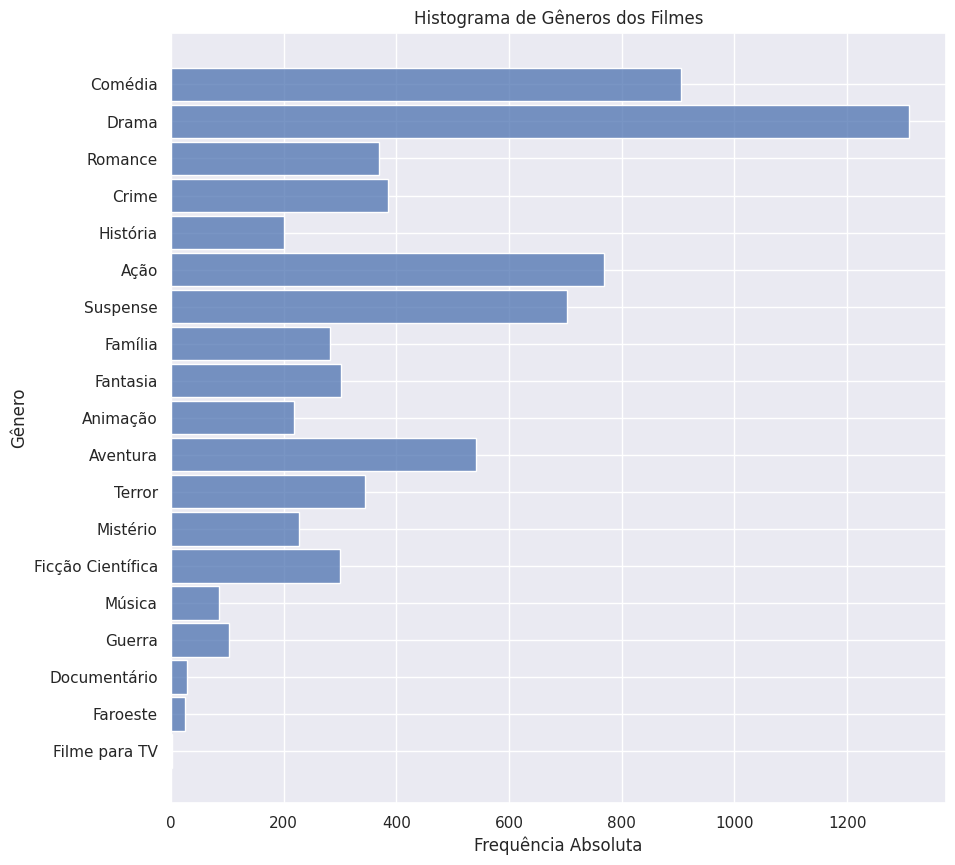

In [10]:
genre_translation = {
    'Action': 'Ação',
    'Adventure': 'Aventura',
    'Animation': 'Animação',
    'Comedy': 'Comédia',
    'Crime': 'Crime',
    'Documentary': 'Documentário',
    'Drama': 'Drama',
    'Family': 'Família',
    'Fantasy': 'Fantasia',
    'History': 'História',
    'Horror': 'Terror',
    'Music': 'Música',
    'Mystery': 'Mistério',
    'Romance': 'Romance',
    'Science Fiction': 'Ficção Científica',
    'Thriller': 'Suspense',
    'TV Movie': 'Filme para TV',
    'War': 'Guerra',
    'Western': 'Faroeste'
}

def translate_genres(genres, translation_dict):
    return [translation_dict.get(genre, genre) for genre in genres]

df = movies_data_by_year['all']
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_genres = df.explode('genres', ignore_index=True).dropna(subset='genres')
df_genres['genres'] = df_genres['genres'].apply(lambda x:genre_translation[x])
print(df_genres['genres'])
# print(df_genres)

# all_genres = [genre for sublist in df['genres'] for genre in sublist]
plt.figure(figsize=(10, 10))
sns.histplot(data=df_genres, y='genres', discrete=True, shrink=0.9)
plt.title('Histograma de Gêneros dos Filmes')
plt.xlabel('Frequência Absoluta')
plt.ylabel('Gênero')
# plt.xticks(rotation=45)
plt.show()


Análise de Gêneros do Elenco

In [11]:
gender_translation = {
    "Not set/not specified": "Não definido / Não especificado",
    "Female": "Mulher",
    "Male": "Homem",
    "Non-binary": "Não-binário"
}

df = movies_data_by_year['all']
df["release_date"] = pd.to_datetime(df["release_date"])
df['year'] = df['release_date'].dt.year

df["cast"] = df["cast"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_exploded = df.explode('cast')

# separa cada key do objeto em uma coluna
df_normalized = pd.concat([df_exploded.drop(['cast'], axis=1), df_exploded['cast'].apply(pd.Series)], axis=1)

gender_counts_per_year_cast = df_normalized.groupby(['year', 'gender']).size().reset_index(name='count')
gender_counts_per_year_cast = gender_counts_per_year_cast.sort_values(by=['year', 'gender'])

gender_counts_per_year_cast['gender'] = gender_counts_per_year_cast['gender'].apply(lambda x:gender_translation[x])


total_counts_per_year = df_normalized.groupby('year').size().reset_index(name='total_count')


gender_counts_per_year_cast_merged = gender_counts_per_year_cast.merge(total_counts_per_year, on='year')
gender_counts_per_year_cast_merged['percentage'] = (gender_counts_per_year_cast_merged['count'] / gender_counts_per_year_cast_merged['total_count']) * 100
gender_counts_per_year_cast_merged = gender_counts_per_year_cast_merged.sort_values(by=['year', 'gender'])

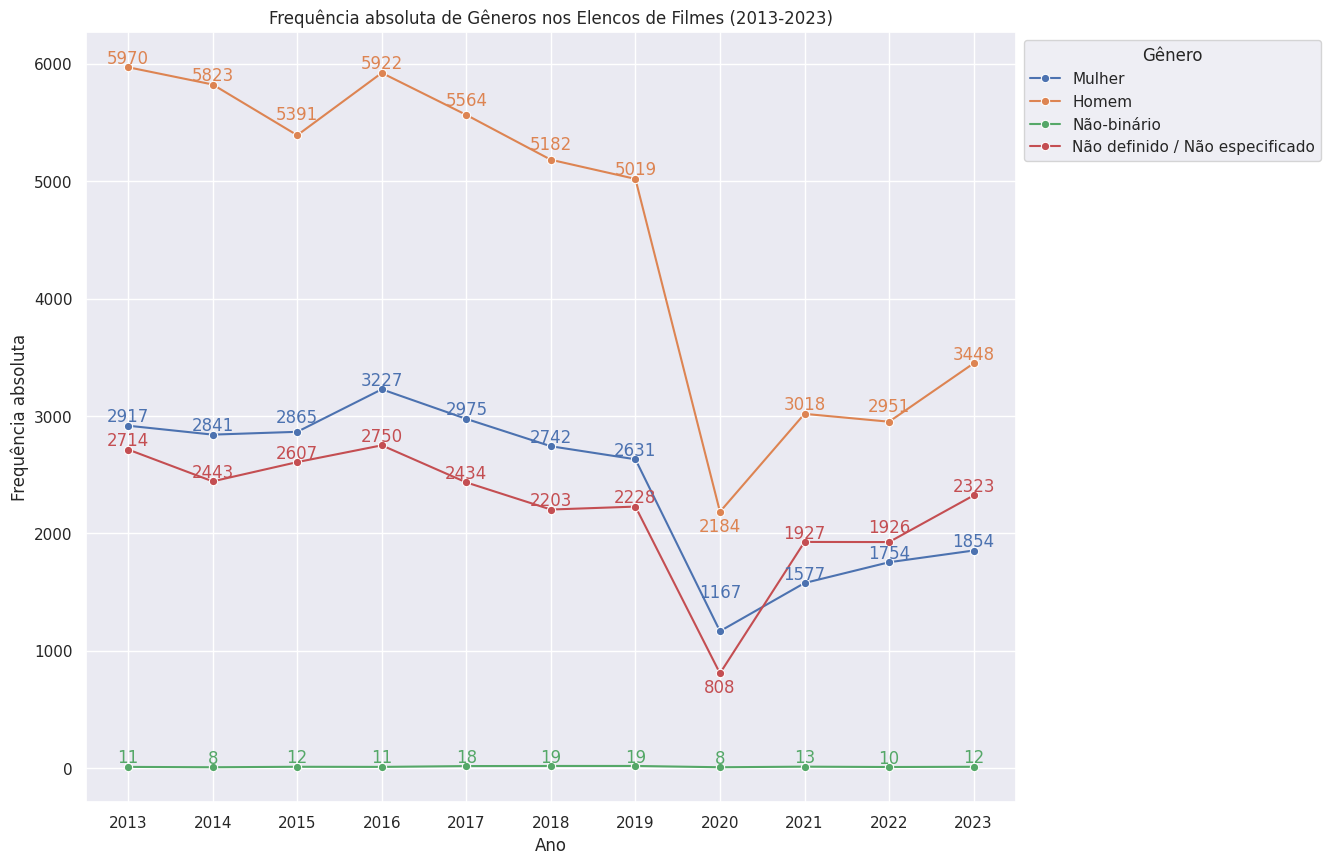

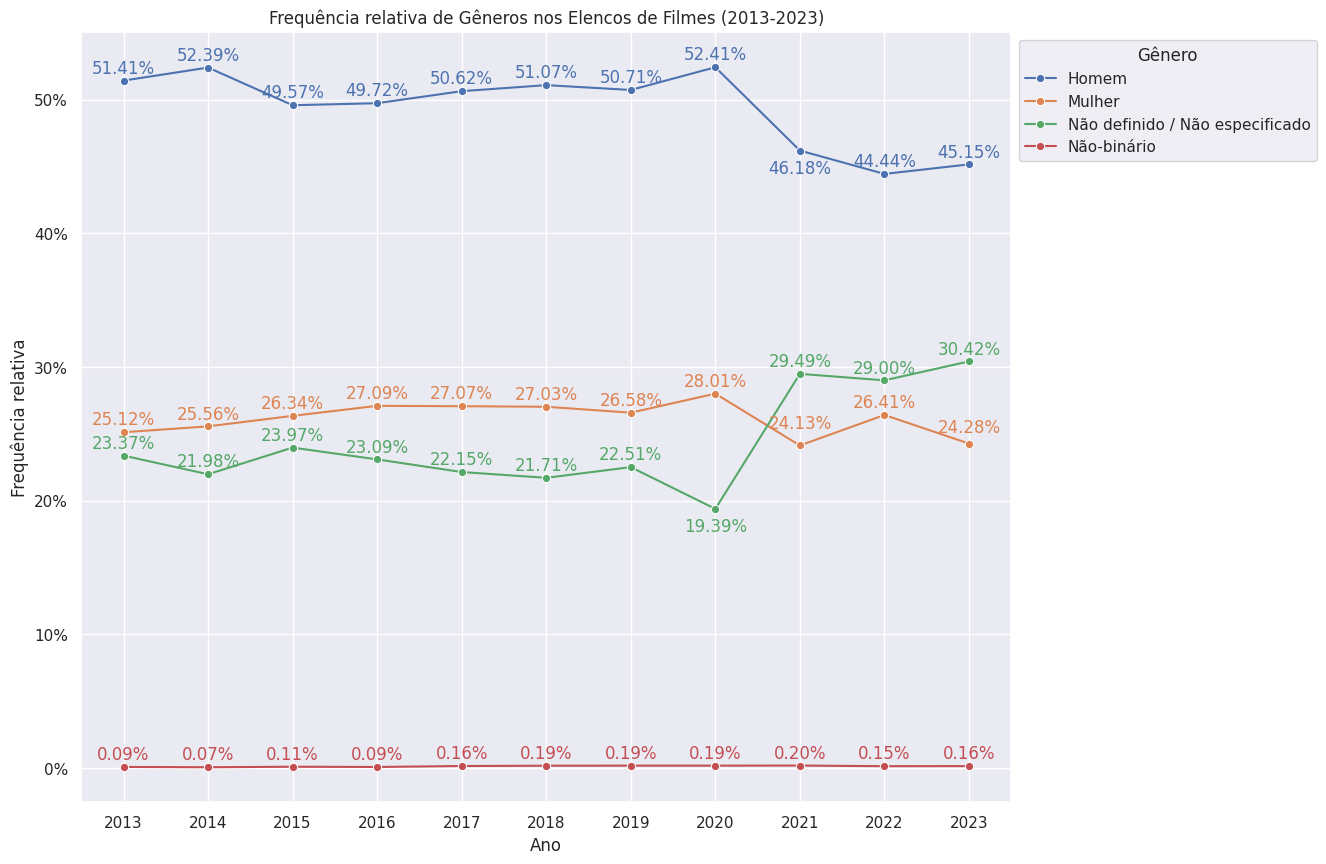

In [12]:
from matplotlib.ticker import FuncFormatter

pos_format = {
    5391: 100,
    5564: 50,
    5182: 50,
    2184: -200,
    2951: 50,
    2447: 50,
    808: -200,
    1926: 50,
    1167: 250,
    2865: 50,
}

plt.figure(figsize=(12, 10))
plot = sns.lineplot(data=gender_counts_per_year_cast, x='year', y='count', hue='gender', marker='o')
plt.xticks(ticks=range(gender_counts_per_year_cast['year'].min(), gender_counts_per_year_cast['year'].max() + 1))
for line in plot.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        if (int(y_value) in pos_format):
            plot.text(x_value, y_value + pos_format[int(y_value)], f'{y_value:.0f}', color=line.get_color(), ha="center", va="bottom")
        else:
            plot.text(x_value, y_value, f'{y_value:.0f}', color=line.get_color(), ha="center", va="bottom")
        

plt.title('Frequência absoluta de Gêneros nos Elencos de Filmes (2013-2023)')
plt.xlabel('Ano')
plt.ylabel('Frequência absoluta')
plt.legend(title='Gênero')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

pos_format = {
    46.18: -2,
    24.13: 0.5,
    19.39: -2,
    24.13: 1,
    24.28: 0.5
}

plt.figure(figsize=(12, 10))
plt.xticks(ticks=range(gender_counts_per_year_cast_merged['year'].min(), gender_counts_per_year_cast['year'].max() + 1))
plot = sns.lineplot(data=gender_counts_per_year_cast_merged, x='year', y='percentage', hue='gender', marker='o', legend="full")

def percentage_formatter(x, pos):
    return f'{x:.0f}%'

for line in plot.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        if (float(f'{y_value:.2f}') in pos_format):
            plot.text(x_value, y_value + pos_format[float(f'{y_value:.2f}')], f'{y_value:.2f}%', color=line.get_color(), ha="center", va="bottom")
        else:
            plot.text(x_value, y_value + 0.25, f'{y_value:.2f}%', color=line.get_color(), ha="center", va="bottom")
        
plot.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.title('Frequência relativa de Gêneros nos Elencos de Filmes (2013-2023)')
plt.xlabel('Ano')
plt.ylabel('Frequência relativa')
plt.legend(title='Gênero')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Grau de importância dos gêneros no elenco

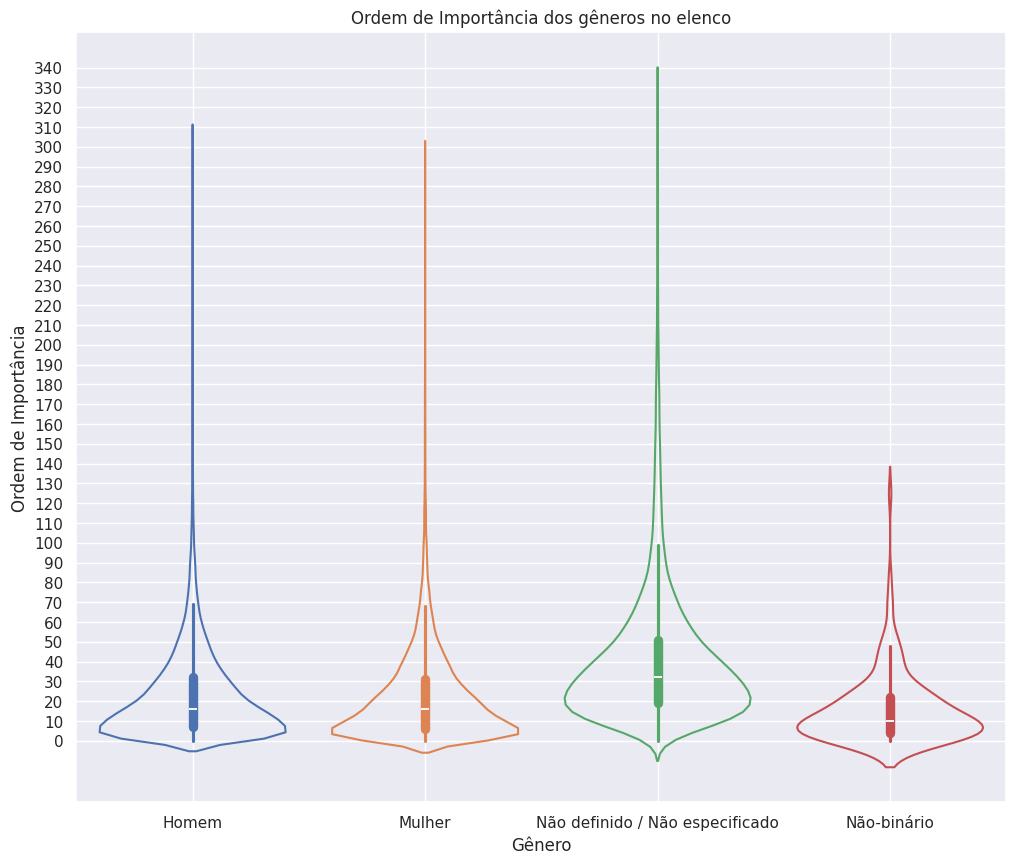

In [13]:
df_normalized_translated = df_normalized.copy()
df_normalized_translated['gender'] = df_normalized['gender'].apply(lambda x:gender_translation[x])

plt.figure(figsize=(12, 10))
sns.violinplot(data=df_normalized_translated, x='gender', y='order', hue='gender', fill=False)
plt.title('Ordem de Importância dos gêneros no elenco')
plt.xlabel('Gênero')
plt.ylabel('Ordem de Importância')
plt.grid(True, which='both', axis='both')

plt.yticks(np.arange(0, 350, 10))

# plt.ylim(-10, 50)
stats = df_normalized.groupby('gender')['order'].describe()
for gender in stats.index:
    median = stats.loc[gender, '50%']
    q1 = stats.loc[gender, '25%']
    q3 = stats.loc[gender, '75%']
    minimum = stats.loc[gender, 'min']
    maximum = stats.loc[gender, 'max']
    
    # Encontrar a posição no eixo x para anotar os valores
    x_pos = df_normalized['gender'].unique().tolist().index(gender)
    
    # Adicionar as anotações ao gráfico
    # plt.text(x_pos, median, f'Mediana: {median:.2f}', horizontalalignment='left', color='black')
    # plt.text(x_pos, q1, f'1Q: {q1:.2f}', horizontalalignment='left', color='blue')
    # plt.text(x_pos, q3, f'3Q: {q3:.2f}', horizontalalignment='left', color='blue')
    # plt.text(x_pos, minimum, f'Min: {minimum:.2f}', horizontalalignment='left', color='red')
    # plt.text(x_pos, maximum, f'Max: {maximum:.2f}', horizontalalignment='left', color='red')


plt.show()

/tmp/ipykernel_18262/2239258896.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Gênero')


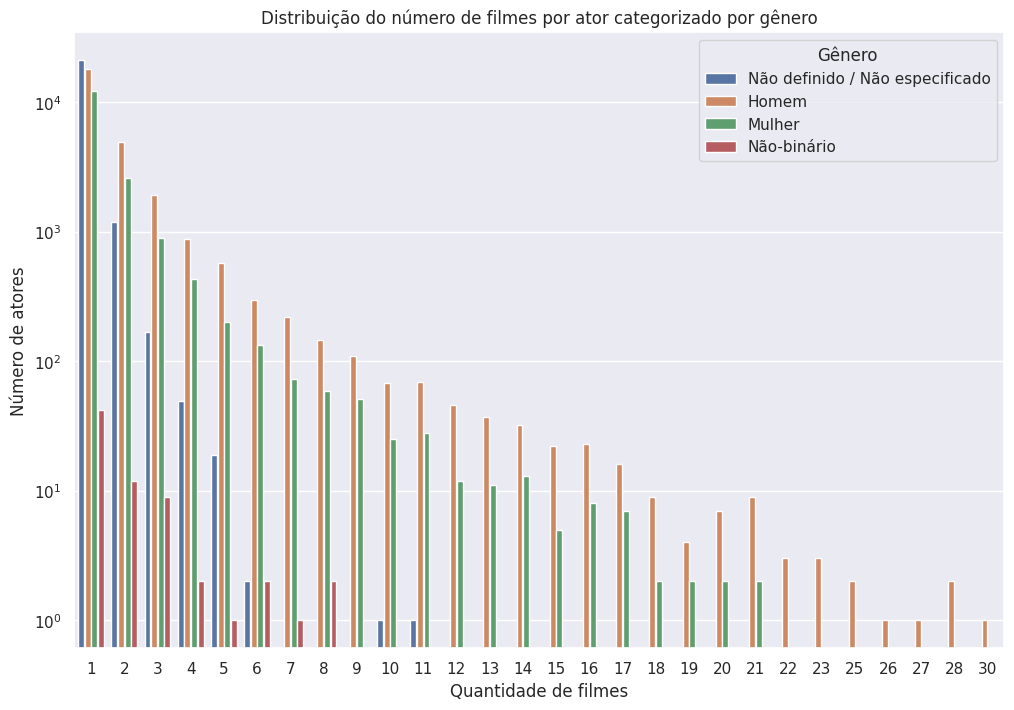

In [14]:
plt.figure(figsize=(12, 8))
plt.title('Distribuição do número de filmes por ator categorizado por gênero')
plt.xlabel('Quantidade de filmes')
plt.ylabel('Número de atores')
plt.yscale('log')
plt.legend(title='Gênero')

# plt.yticks(np.arange(0, 11, 1))
top_names = df_normalized_translated[["gender", "name"]].value_counts().reset_index(name='movies_amount')
movies_count = top_names[['movies_amount', 'gender']].value_counts().reset_index()
movies_count
movies_count.columns = ['movies_amount', 'gender', 'num_actors']
plt.yscale('log')
ax = sns.barplot(x='movies_amount', y='num_actors', data=movies_count, hue="gender", gap= 0.1)
ax.get_legend().set_title("Gênero")
# ax.tick_params(axis='x', labelsize=10)


# top_names = top_names.groupby('gender').head(20)
# sns.histplot(x='count', y='gender', data=top_names, hue='gender')

# sns.barplot(x='count', y='name', hue='gender', data=top_names, orient='h')

# plt.show()
# plt.xticks(np.arange(0, 31, 1))
# plt.grid(True, which='both', axis='both')
# sns.barplot(data=top_names, x="count", hue="gender",  multiple="stack", bins=50)
# plt.show()

# top_names

Análise Gênero da produção

In [15]:
gender_translation = {
    "Not set/not specified": "Não definido / Não especificado",
    "Female": "Mulher",
    "Male": "Homem",
    "Non-binary": "Não-binário"
}

df = movies_data_by_year['all']
df["release_date"] = pd.to_datetime(df["release_date"])
df['year'] = df['release_date'].dt.year

df["crew"] = df["crew"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_exploded = df.explode('crew')

# separa cada key do objeto em uma coluna
df_normalized = pd.concat([df_exploded.drop(['crew'], axis=1), df_exploded['crew'].apply(pd.Series)], axis=1)

gender_counts_per_year_crew = df_normalized.groupby(['year', 'gender']).size().reset_index(name='count')
gender_counts_per_year_crew = gender_counts_per_year_crew.sort_values(by=['year', 'gender'])

gender_counts_per_year_crew['gender'] = gender_counts_per_year_crew['gender'].apply(lambda x:gender_translation[x])


total_counts_per_year = df_normalized.groupby('year').size().reset_index(name='total_count')


gender_counts_per_year_crew_merged = gender_counts_per_year_crew.merge(total_counts_per_year, on='year')
gender_counts_per_year_crew_merged['percentage'] = (gender_counts_per_year_crew_merged['count'] / gender_counts_per_year_crew_merged['total_count']) * 100
gender_counts_per_year_crew_merged = gender_counts_per_year_crew_merged.sort_values(by=['year', 'gender'])

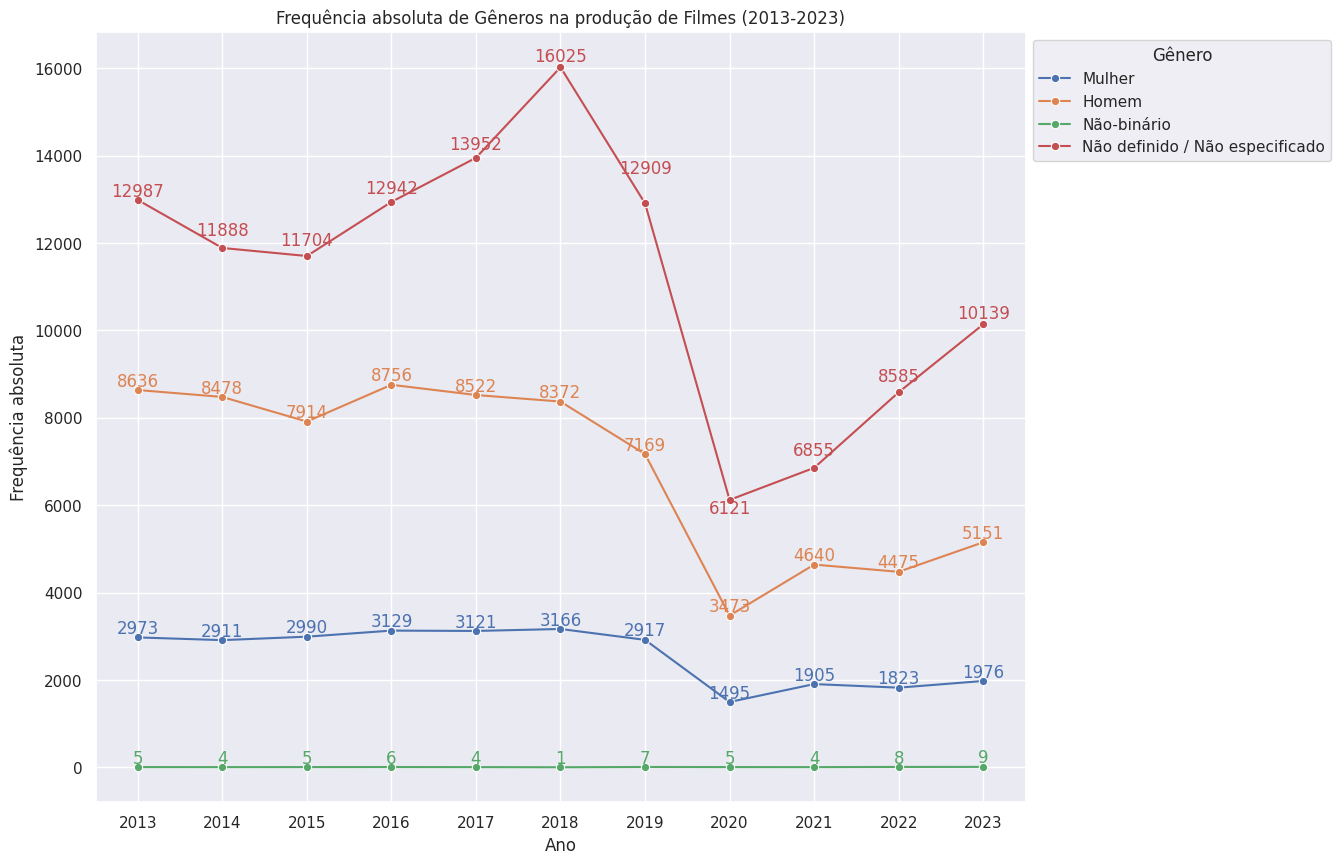

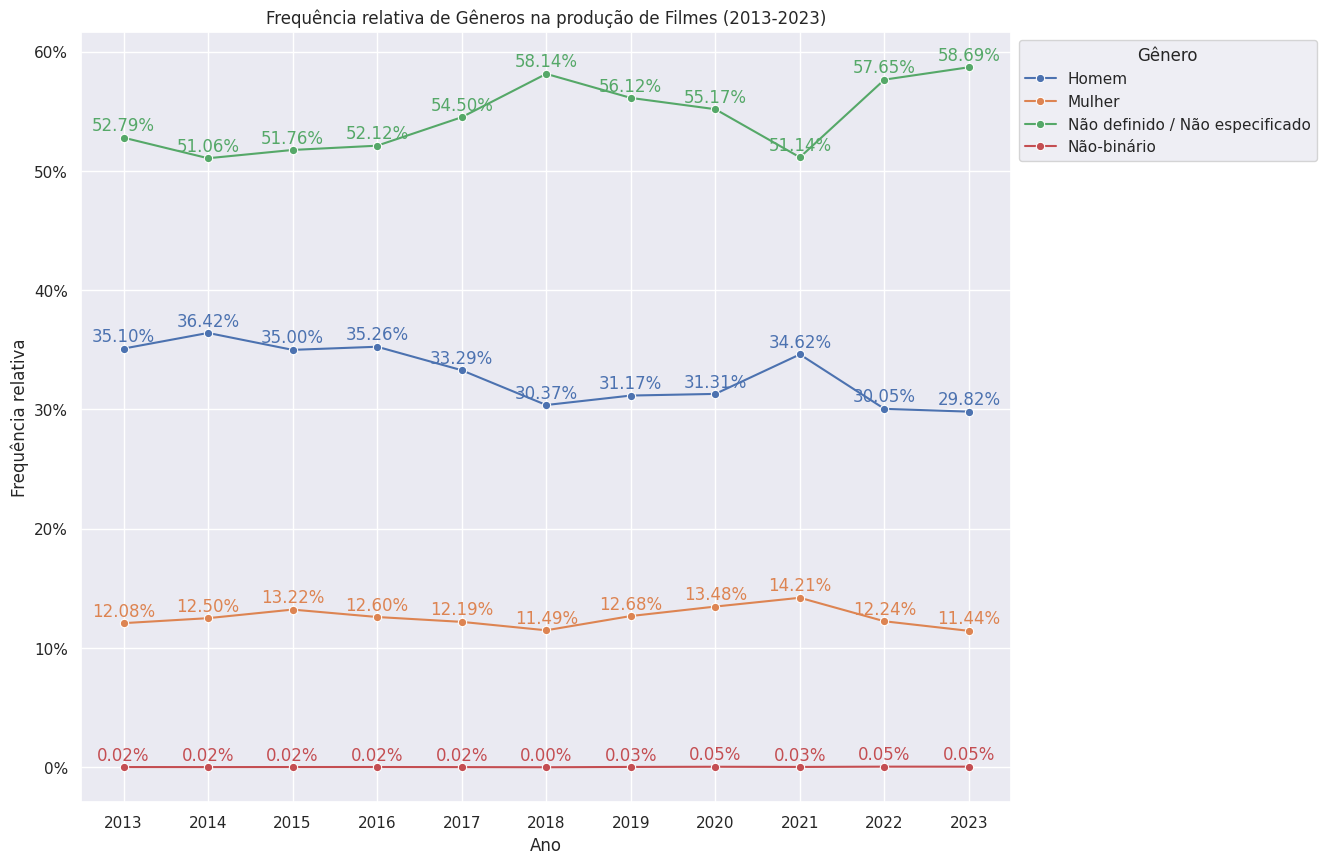

In [16]:
from matplotlib.ticker import FuncFormatter

pos_format = {
    11888: 200,
    11704: 150,
    12942: 100,
    13952: 100,
    16025: 50,
    12909: 600,
    6121: -400,
    6855: 200,
    8585: 150,
    10139: 50,
}

plt.figure(figsize=(12, 10))
plot = sns.lineplot(data=gender_counts_per_year_crew, x='year', y='count', hue='gender', marker='o')
plt.xticks(ticks=range(gender_counts_per_year_crew['year'].min(), gender_counts_per_year_crew['year'].max() + 1))
for line in plot.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        if (int(y_value) in pos_format):
            plot.text(x_value, y_value + pos_format[int(y_value)], f'{y_value:.0f}', color=line.get_color(), ha="center", va="bottom")
        else:
            plot.text(x_value, y_value, f'{y_value:.0f}', color=line.get_color(), ha="center", va="bottom")
        

plt.title('Frequência absoluta de Gêneros na produção de Filmes (2013-2023)')
plt.xlabel('Ano')
plt.ylabel('Frequência absoluta')
plt.legend(title='Gênero')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# pos_format = {
#     46.18: -2,
#     24.13: 0.5,
#     19.39: -2,
#     24.13: 1,
#     24.28: 0.5
# }

plt.figure(figsize=(12, 10))
plt.xticks(ticks=range(gender_counts_per_year_crew_merged['year'].min(), gender_counts_per_year_crew['year'].max() + 1))
plot = sns.lineplot(data=gender_counts_per_year_crew_merged, x='year', y='percentage', hue='gender', marker='o', legend="full")

def percentage_formatter(x, pos):
    return f'{x:.0f}%'

for line in plot.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        # if (float(f'{y_value:.2f}') in pos_format):
        #     plot.text(x_value, y_value + pos_format[float(f'{y_value:.2f}')], f'{y_value:.2f}%', color=line.get_color(), ha="center", va="bottom")
        # else:
        plot.text(x_value, y_value + 0.25, f'{y_value:.2f}%', color=line.get_color(), ha="center", va="bottom")
        
plot.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.title('Frequência relativa de Gêneros na produção de Filmes (2013-2023)')
plt.xlabel('Ano')
plt.ylabel('Frequência relativa')
plt.legend(title='Gênero')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

/tmp/ipykernel_18262/1145882363.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["job"] = filtered["job"].apply(lambda x: jobs_translation[x] if x in jobs_translation else x)


[]

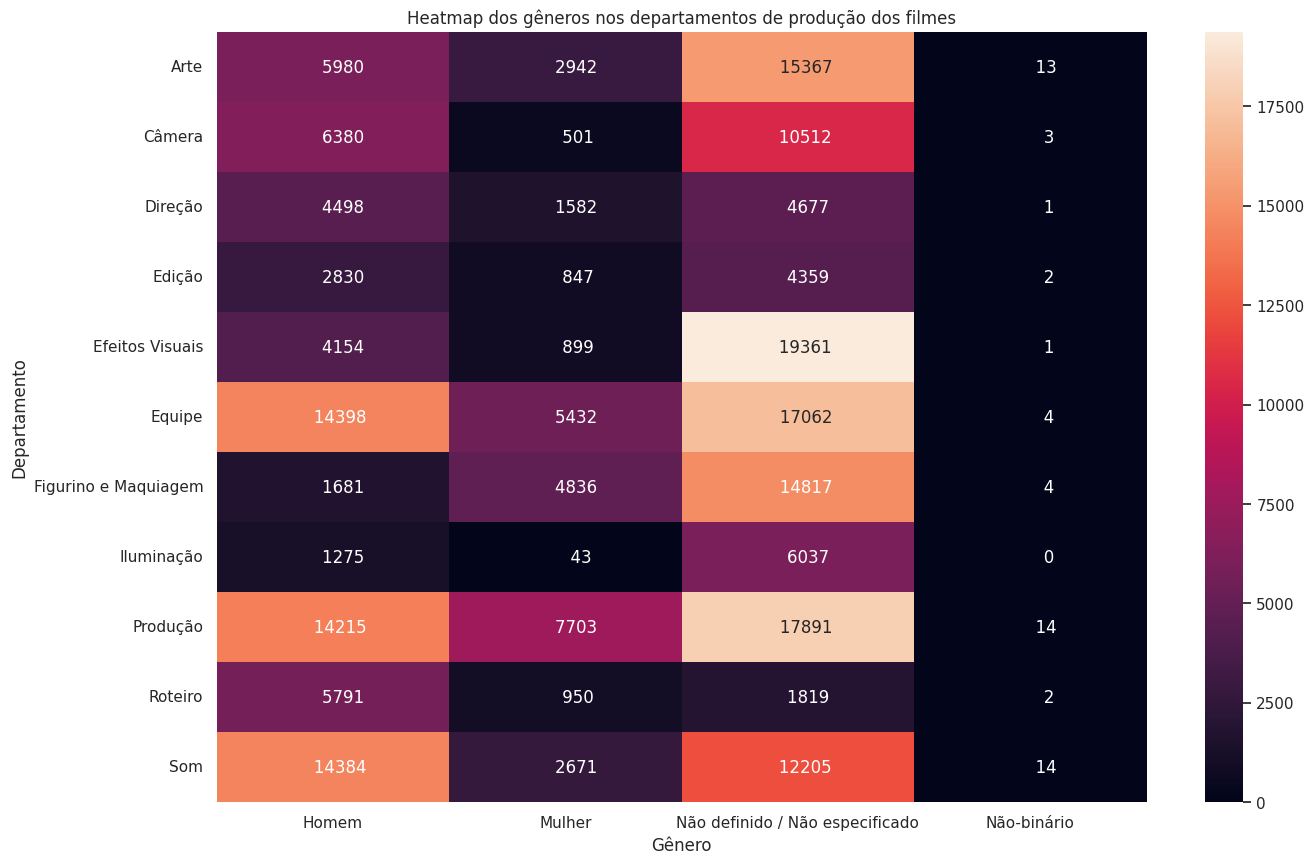

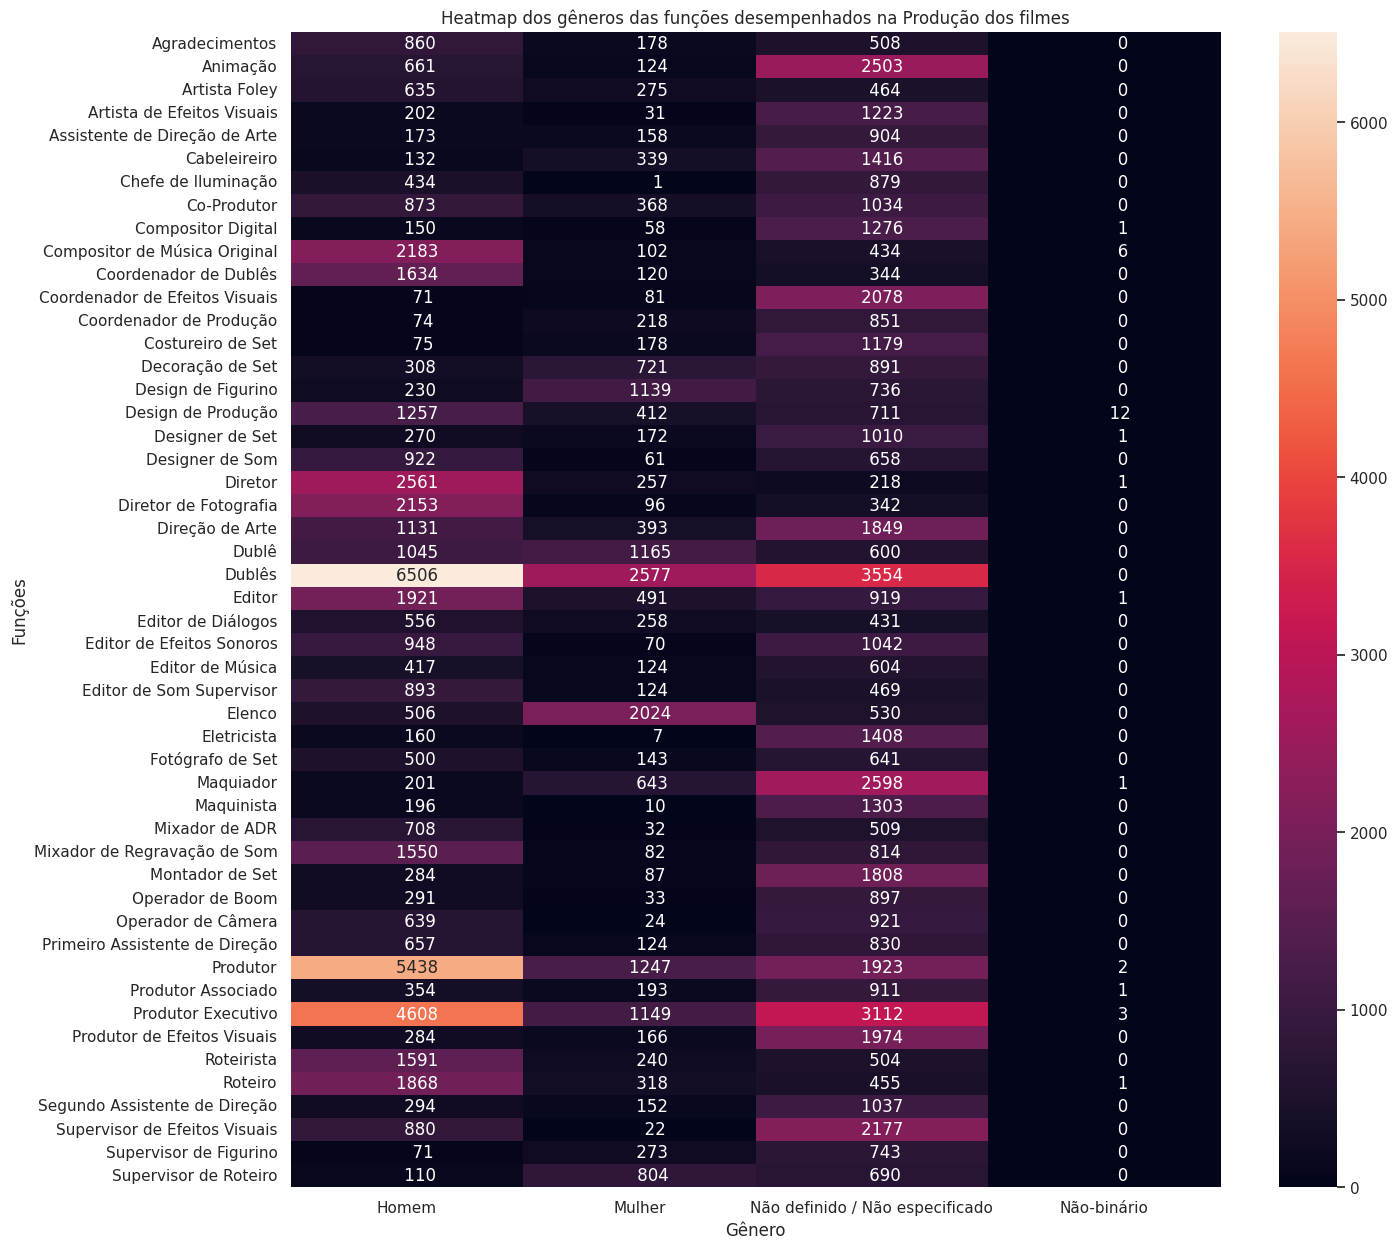

In [17]:
departments_translation = {
    "Art": "Arte",
    "Camera": "Câmera",
    "Costume & Make-Up": "Figurino e Maquiagem",
    "Crew": "Equipe",
    "Directing": "Direção",
    "Editing": "Edição",
    "Lighting": "Iluminação",
    "Production": "Produção",
    "Sound": "Som",
    "Visual Effects": "Efeitos Visuais",
    "Writing": "Roteiro"
}

jobs_translation = {
    "ADR Mixer": "Mixador de ADR",
    "Animation": "Animação",
    "Art Direction": "Direção de Arte",
    "Assistant Art Director": "Assistente de Direção de Arte",
    "Associate Producer": "Produtor Associado",
    "Boom Operator": "Operador de Boom",
    "Camera Operator": "Operador de Câmera",
    "Casting": "Elenco",
    "Co-Producer": "Co-Produtor",
    "Costume Design": "Design de Figurino",
    "Costume Supervisor": "Supervisor de Figurino",
    "Dialogue Editor": "Editor de Diálogos",
    "Digital Compositor": "Compositor Digital",
    "Director": "Diretor",
    "Director of Photography": "Diretor de Fotografia",
    "Editor": "Editor",
    "Electrician": "Eletricista",
    "Executive Producer": "Produtor Executivo",
    "First Assistant Director": "Primeiro Assistente de Direção",
    "Foley Artist": "Artista Foley",
    "Gaffer": "Chefe de Iluminação",
    "Grip": "Maquinista",
    "Hairstylist": "Cabeleireiro",
    "Makeup Artist": "Maquiador",
    "Music Editor": "Editor de Música",
    "Original Music Composer": "Compositor de Música Original",
    "Producer": "Produtor",
    "Production Coordinator": "Coordenador de Produção",
    "Production Design": "Design de Produção",
    "Screenplay": "Roteiro",
    "Script Supervisor": "Supervisor de Roteiro",
    "Second Assistant Director": "Segundo Assistente de Direção",
    "Set Costumer": "Costureiro de Set",
    "Set Decoration": "Decoração de Set",
    "Set Designer": "Designer de Set",
    "Set Dresser": "Montador de Set",
    "Sound Designer": "Designer de Som",
    "Sound Effects Editor": "Editor de Efeitos Sonoros",
    "Sound Re-Recording Mixer": "Mixador de Regravação de Som",
    "Still Photographer": "Fotógrafo de Set",
    "Stunt Coordinator": "Coordenador de Dublês",
    "Stunt Double": "Dublê",
    "Stunts": "Dublês",
    "Supervising Sound Editor": "Editor de Som Supervisor",
    "Thanks": "Agradecimentos",
    "VFX Artist": "Artista de Efeitos Visuais",
    "Visual Effects Coordinator": "Coordenador de Efeitos Visuais",
    "Visual Effects Producer": "Produtor de Efeitos Visuais",
    "Visual Effects Supervisor": "Supervisor de Efeitos Visuais",
    "Writer": "Roteirista"
}

df_normalized_translated = df_normalized.copy()
df_normalized_translated['gender'] = df_normalized['gender'].apply(lambda x:gender_translation[x])

df = df_normalized_translated.copy()

df['department'] = df['department'].apply(lambda x: departments_translation[x] if x in departments_translation else x)

plt.figure(figsize=(15, 10))
sns.heatmap(df.pivot_table(index="department", columns="gender", aggfunc='size', fill_value=0), annot=True, fmt="8.0f")

plt.title('Heatmap dos gêneros nos departamentos de produção dos filmes')
plt.xlabel('Gênero')
plt.ylabel('Departamento')

plt.plot()

value_counts = df["job"].value_counts()


# plt.figure(figsize=(12, 10))
# sns.heatmap(df_normalized_translated.pivot_table(index="job", columns="gender", aggfunc='size', fill_value=0), annot=True, fmt="8.0f")
# plt.plot()

values_to_keep = value_counts.head(50).index

filtered = df_normalized_translated[df_normalized_translated["job"].isin(values_to_keep)]

filtered["job"] = filtered["job"].apply(lambda x: jobs_translation[x] if x in jobs_translation else x)

plt.figure(figsize=(15, 15))
sns.heatmap(filtered.pivot_table(index="job", columns="gender", aggfunc='size', fill_value=0), annot=True, fmt="8.0f")

plt.title('Heatmap dos gêneros das funções desempenhados na Produção dos filmes')
plt.xlabel('Gênero')
plt.ylabel('Funções')

plt.plot()



In [18]:
# plt.figure(figsize=(12, 8))
# plt.title('Distribuição do número de filmes por pessoa da produção categorizado por gênero')
# plt.xlabel('Quantidade de filmes')
# plt.ylabel('Número de pessoas')
# plt.yscale('log')
# plt.legend(title='Gênero')

# # plt.yticks(np.arange(0, 11, 1))
# movies_count = top_names[['movies_amount', 'gender']].value_counts().reset_index()
# movies_count
# movies_count.columns = ['movies_amount', 'gender', 'num_actors']
# plt.yscale('log')
# ax = sns.barplot(x='movies_amount', y='num_actors', data=movies_count, hue="gender", gap= 0.1)
# ax.get_legend().set_title("Gênero")
df_normalized


,id,original_language,original_title,overview,release_date,title,vote_average,vote_count,belongs_to_collection,budget,...,spoken_languages,tagline,cast,keywords,year,gender,known_for_department,name,department,job
0,87567,en,The Big Wedding,To the amusement of their adult children and f...,2013-04-25,The Big Wedding,5.869,1111,NaN,35000000.0,...,"['English', 'Spanish', 'Latin']",It's never too late to start acting like a fam...,"[{'gender': 'Male', 'known_for_department': 'A...","[language barrier, betrayal, wedding, family, ...",2013,Male,Writing,Justin Zackham,Directing,Director
0,87567,en,The Big Wedding,To the amusement of their adult children and f...,2013-04-25,The Big Wedding,5.869,1111,NaN,35000000.0,...,"['English', 'Spanish', 'Latin']",It's never too late to start acting like a fam...,"[{'gender': 'Male', 'known_for_department': 'A...","[language barrier, betrayal, wedding, family, ...",2013,Male,Sound,Nathan Barr,Sound,Original Music Composer
0,87567,en,The Big Wedding,To the amusement of their adult children and f...,2013-04-25,The Big Wedding,5.869,1111,NaN,35000000.0,...,"['English', 'Spanish', 'Latin']",It's never too late to start acting like a fam...,"[{'gender': 'Male', 'known_for_department': 'A...","[language barrier, betrayal, wedding, family, ...",2013,Male,Production,Harry J. Ufland,Production,Producer
0,87567,en,The Big Wedding,To the amusement of their adult children and f...,2013-04-25,The Big Wedding,5.869,1111,NaN,35000000.0,...,"['English', 'Spanish', 'Latin']",It's never too late to start acting like a fam...,"[{'gender': 'Male', 'known_for_department': 'A...","[language barrier, betrayal, wedding, family, ...",2013,Male,Directing,Jean-Stéphane Bron,Writing,Screenstory
0,87567,en,The Big Wedding,To the amusement of their adult children and f...,2013-04-25,The Big Wedding,5.869,1111,NaN,35000000.0,...,"['English', 'Spanish', 'Latin']",It's never too late to start acting like a fam...,"[{'gender': 'Male', 'known_for_department': 'A...","[language barrier, betrayal, wedding, family, ...",2013,Female,Editing,Karine Sudan,Writing,Screenstory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,925263,it,Il sol dell'avvenire,An old film director unhappy with the movie he...,2023-04-20,A Brighter Tomorrow,7.100,263,NaN,13266839.0,...,"['Korean', 'French', 'Hungarian', 'Italian', '...",NaN,"[{'gender': 'Male', 'known_for_department': 'D...",[filmmaking],2023,Not set/not specified,Sound,Alessandro Zanon,Sound,Sound
206,925263,it,Il sol dell'avvenire,An old film director unhappy with the movie he...,2023-04-20,A Brighter Tomorrow,7.100,263,NaN,13266839.0,...,"['Korean', 'French', 'Hungarian', 'Italian', '...",NaN,"[{'gender': 'Male', 'known_for_department': 'D...",[filmmaking],2023,Male,Directing,Nanni Moretti,Writing,Story
206,925263,it,Il sol dell'avvenire,An old film director unhappy with the movie he...,2023-04-20,A Brighter Tomorrow,7.100,263,NaN,13266839.0,...,"['Korean', 'French', 'Hungarian', 'Italian', '...",NaN,"[{'gender': 'Male', 'known_for_department': 'D...",[filmmaking],2023,Not set/not specified,Writing,Valia Santella,Writing,Story
206,925263,it,Il sol dell'avvenire,An old film director unhappy with the movie he...,2023-04-20,A Brighter Tomorrow,7.100,263,NaN,13266839.0,...,"['Korean', 'French', 'Hungarian', 'Italian', '...",NaN,"[{'gender': 'Male', 'known_for_department': 'D...",[filmmaking],2023,Female,Writing,Francesca Marciano,Writing,Story


Stripplot de genero e orçamento dos filmes

In [19]:
# def count_genders(people_list):
#     gender_count = {}
        
#     for person in people_list:
#         gender = person['gender']
        
#         if gender in gender_count:
#             gender_count[gender] += 1
#         else:
#             gender_count[gender] = 1
    
#     return pd.Series(gender_count)

# df = movies_data_by_year['all']
# df["crew"] = df["crew"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# df["cast"] = df["cast"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# df

# # count_genders(df['cast'])
# # print(count_genders(df['cast'].head(1)[0]))

# cast_count = df['cast'].apply(count_genders).fillna(0)
# crew_count = df['crew'].apply(count_genders).fillna(0)

# gender_sum = crew_count + cast_count


# # df.concat(crew_count + cast_count)

# df = pd.concat([df, gender_sum], axis=1)

# df


# plt.figure(figsize=(10, 6))

# # Plot budget vs female count
# sns.scatterplot(data=df, x='budget', y='Female', color='blue', label='Female Count')

# # Plot budget vs male count
# sns.scatterplot(data=df, x='budget', y='Male', color='green', label='Male Count')

# # Plot budget vs not specified count
# # sns.scatterplot(data=df, x='budget', y='Not set/not specified', color='orange', label='Not Specified Count')

# sns.scatterplot(data=df, x='budget', y='Non-binary', color='red', label='Non-binary Count')

# # Add labels and title
# plt.title('Relationship between Gender Counts and Budget')
# plt.xlabel('Budget')
# plt.ylabel('Number of People')
# plt.legend()

# # Show the plot
# plt.show()




Análise econômica

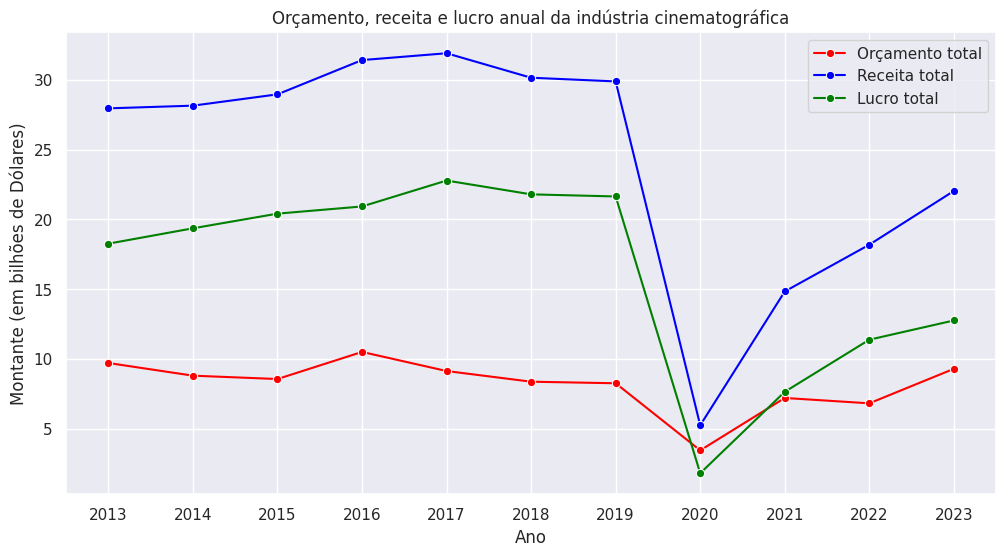

In [20]:
#Evolução anual do investimento dos filmes

totals = []

for year in range(start_year, end_year+1):
    billion = 1000000000
    df = movies_data_by_year[year]
    total_budget = df['budget'].sum() / billion
    total_revenue = df['revenue'].sum() / billion
    total_profit = total_revenue - total_budget
    totals.append({'year': year, 'total_budget': total_budget, 'total_revenue': total_revenue, 'total_profit': total_profit})
    
financial_totals = pd.DataFrame(totals)

# Crie o line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=financial_totals, x='year', y='total_budget', marker='o', label='Orçamento total', color='red')
sns.lineplot(data=financial_totals, x='year', y='total_revenue', marker='o', label='Receita total', color='blue')
sns.lineplot(data=financial_totals, x='year', y='total_profit', marker='o', label='Lucro total', color='green')


plt.title('Orçamento, receita e lucro anual da indústria cinematográfica')
plt.xlabel('Ano')
plt.ylabel('Montante (em bilhões de Dólares)')
plt.xticks(financial_totals['year'])  # Mostra todos os anos no eixo x
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()


Sucesso financeiro dos filmes em relação ao gênero

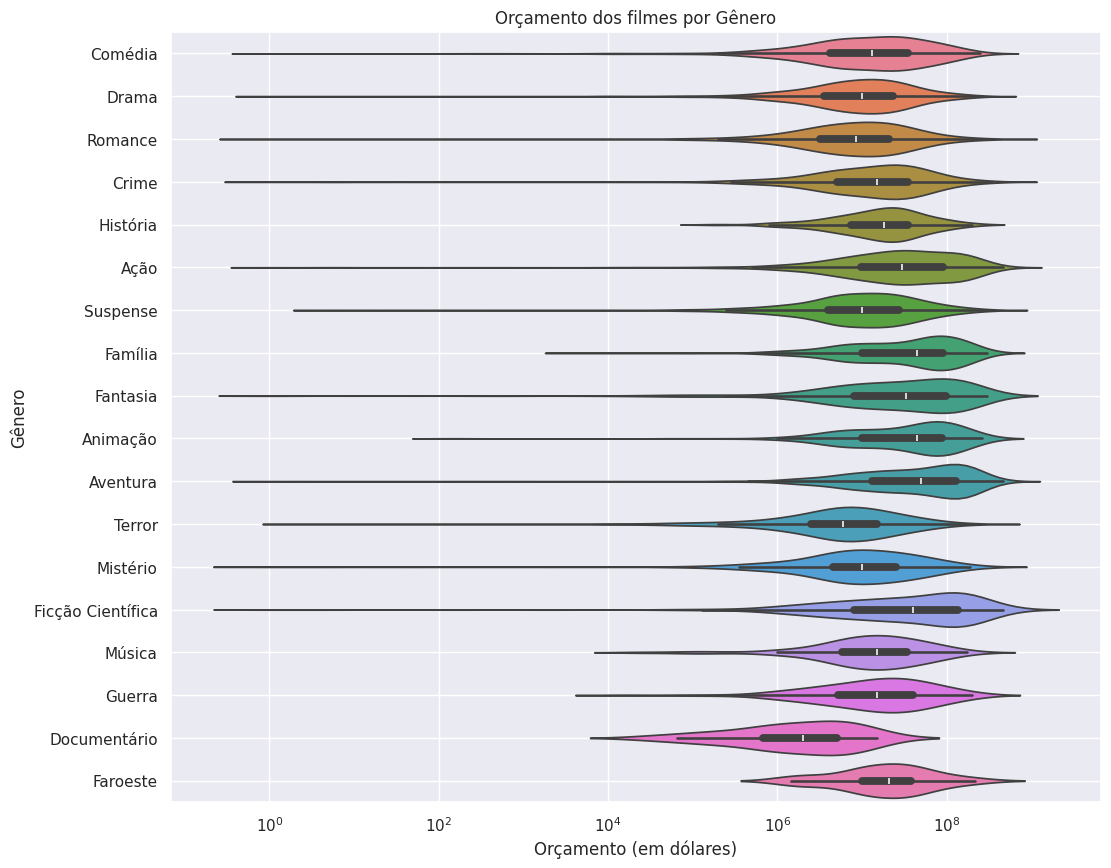

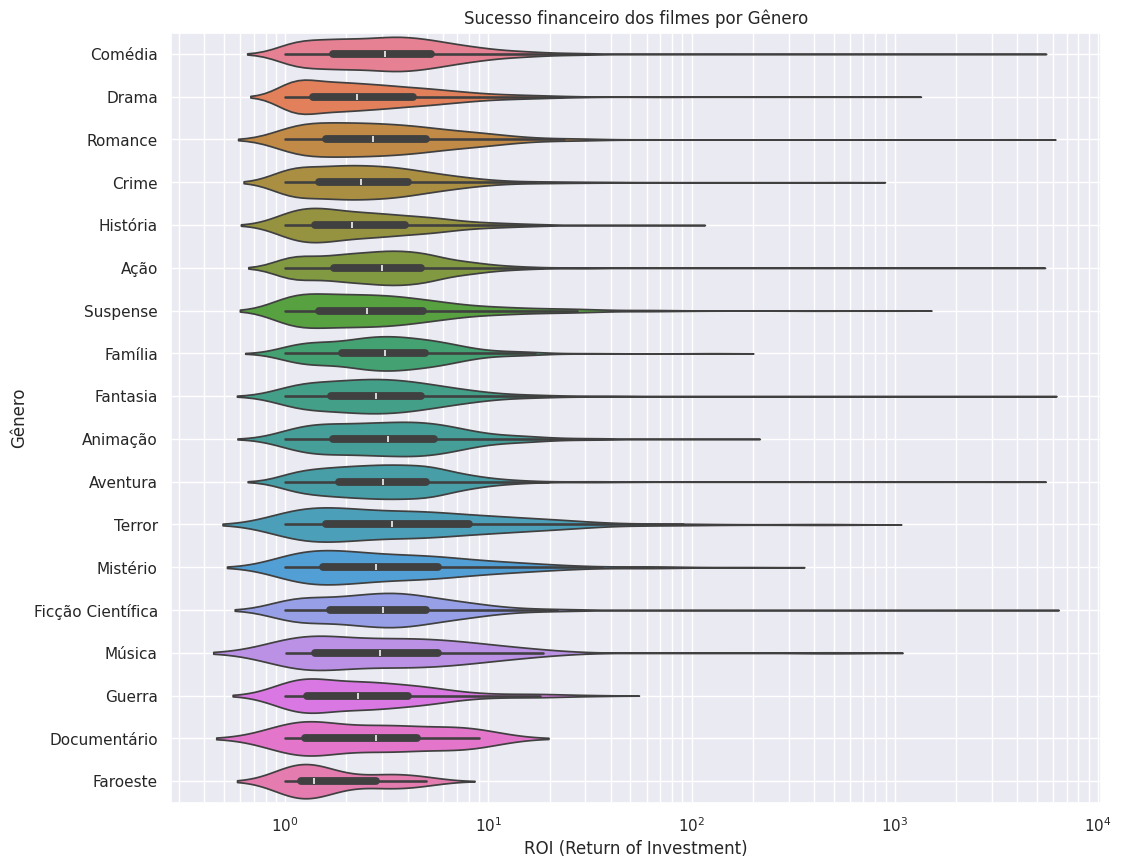

In [80]:
# Violin plot

# df = movies_data_by_year['all']

# df_roi_genres = df.explode('genres', ignore_index=True)

# df_roi_genres['genres']

df_genres_roi = df_genres.copy()
roi = ((df_genres_roi['revenue'] - df_genres_roi['budget']) / df_genres_roi['budget']) + 2
df_genres_roi['roi'] = roi
# df_genres_roi['roi'] = np.log10(df_genres_roi['roi'])

# df_genres_roi.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# df_normalized_translated = df_normalized.copy()
# df_normalized_translated['gender'] = df_normalized['gender'].apply(lambda x:gender_translation[x])

# df_genres_roi.dtypes

# plt.figure(figsize=(10, 10))
# sns.histplot(data=df_genres_roi, y='genres', discrete=True, shrink=0.9)
# plt.title('Histograma de Gêneros dos Filmes')
# plt.xlabel('Frequência Absoluta')
# plt.ylabel('Gênero')
# plt.xticks(rotation=45)
# plt.show()

df_genres_roi = df_genres_roi[df_genres_roi.genres != 'Filme para TV']


plt.figure(figsize=(12, 10))
sns.violinplot(data=df_genres_roi, x='budget', y='genres', hue='genres', log_scale=True)
plt.title('Orçamento dos filmes por Gênero')
plt.xlabel('Orçamento (em dólares)')
plt.ylabel('Gênero')
plt.grid(True, which='both', axis='both')


plt.figure(figsize=(12, 10))
sns.violinplot(data=df_genres_roi, x='roi', y='genres', hue='genres', log_scale=True)
plt.title('Sucesso financeiro dos filmes por Gênero')
plt.xlabel('ROI (Return of Investment)')
plt.ylabel('Gênero')
plt.grid(True, which='both', axis='both')

# stats = df_genres_roi.groupby('genres')['roi'].describe()
# for genre in stats.index:
#     median = stats.loc[genre, '50%']
#     q1 = stats.loc[genre, '25%']
#     q3 = stats.loc[genre, '75%']
#     minimum = stats.loc[genre, 'min']
#     maximum = stats.loc[genre, 'max']
    
#     print(genre, q1, median, q3, minimum, maximum)
    
#     # Encontrar a posição no eixo x para anotar os valores
#     x_pos = df_genres_roi['genres'].unique().tolist().index(genre)
    
#     # Adicionar as anotações ao gráfico
#     plt.text(x_pos, median, f'Mediana: {median:.2f}', horizontalalignment='left', color='black')
#     plt.text(x_pos, q1, f'1Q: {q1:.2f}', horizontalalignment='left', color='blue')
#     plt.text(x_pos, q3, f'3Q: {q3:.2f}', horizontalalignment='left', color='blue')
#     plt.text(x_pos, minimum, f'Min: {minimum:.2f}', horizontalalignment='left', color='red')
#     plt.text(x_pos, maximum, f'Max: {maximum:.2f}', horizontalalignment='left', color='red')


# df_genres_roi[df_genres_roi['roi'] > 3000]

# df[df['roi'] == 0]
plt.show()



Sucesso financeiro dos filmes em relação a coleções

0

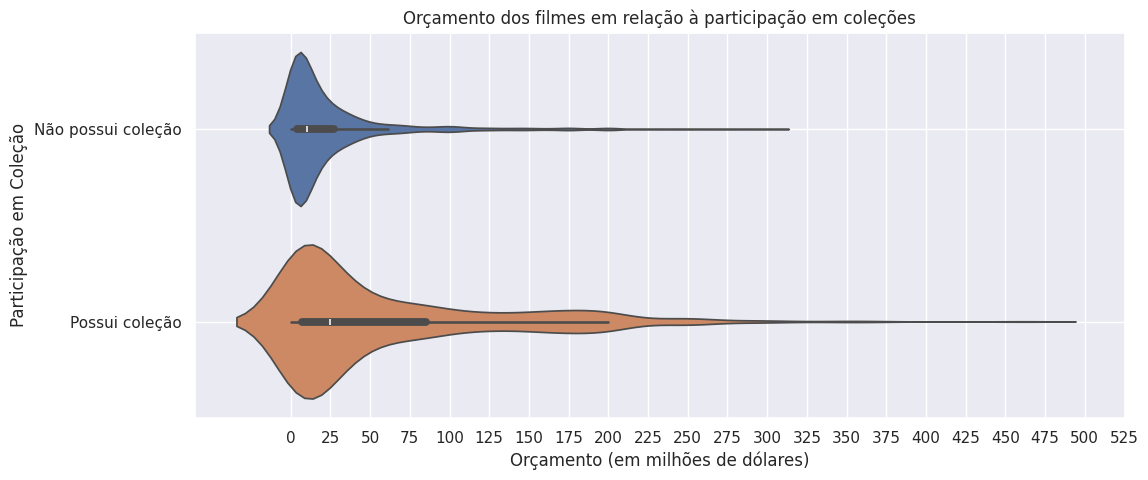

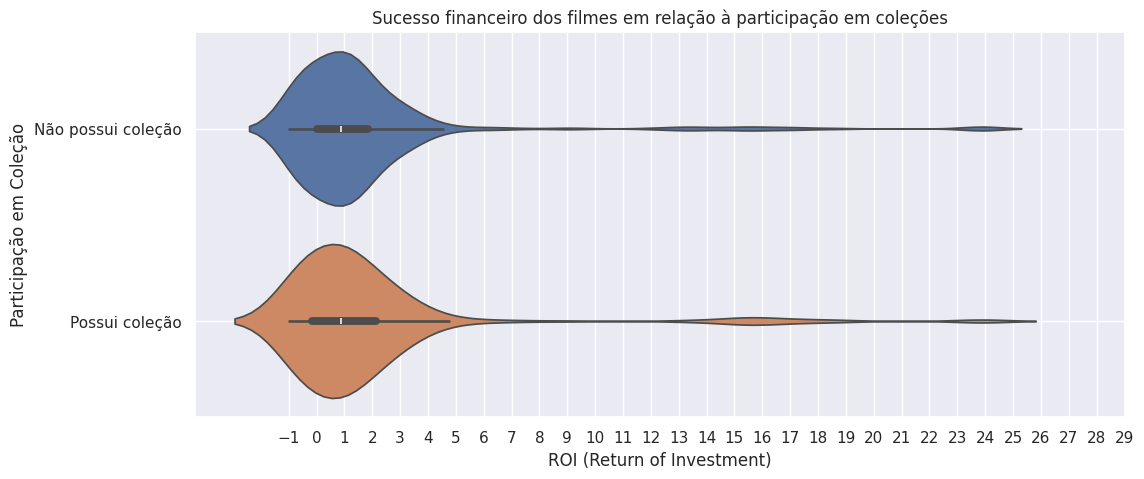

In [105]:
df = movies_data_by_year['all']

df['belongs_to_collection'] = df['belongs_to_collection'].fillna(False).apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['in_collection'] = df['belongs_to_collection'].apply(lambda x: 'Possui coleção' if x else 'Não possui coleção')
df['roi']= roi


million = 1000000

plt.figure(figsize=(12, 5))
sns.violinplot(data=df, x=df['budget']/million, y='in_collection', hue='in_collection')
plt.title('Orçamento dos filmes em relação à participação em coleções')
plt.xlabel('Orçamento (em milhões de dólares)')
plt.ylabel('Participação em Coleção')
plt.grid(True, which='both', axis='both')
plt.xticks(range(0, 550, 25))

plt.figure(figsize=(12, 5))
sns.violinplot(data=df, x=df['roi'] - 2, y='in_collection', hue='in_collection')
plt.title('Sucesso financeiro dos filmes em relação à participação em coleções')
plt.xlabel('ROI (Return of Investment)')
plt.ylabel('Participação em Coleção')
plt.grid(True, which='both', axis='both')
plt.xticks(range(-1, 30, 1))

# df[df['belongs_to_collection'] != False].iloc[0]['belongs_to_collection']


In [ ]:
df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['roi'] = roi
df_exploded = df.explode('production_companies')

# df_exploded['production_companies'].value_counts().head(20)
# df_exploded['company_name'] = df['production_companies'].apply(lambda x: x.name)
df_exploded['production_companies']

id                                                                   87567
original_language                                                       en
original_title                                             The Big Wedding
overview                 To the amusement of their adult children and f...
release_date                                           2013-04-25 00:00:00
title                                                      The Big Wedding
vote_average                                                         5.869
vote_count                                                            1111
belongs_to_collection                                                False
budget                                                          35000000.0
genres                                                            [Comedy]
production_companies     {'name': 'Millennium Media', 'origin_country':...
production_countries                          ['United States of America']
revenue                  